In [2]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
from PIL import Image


In [89]:
random.seed(63)

In [10]:
# Filter the images before adding them to image folder
class FilteredImageFolder(dset.ImageFolder):
    def __init__(self, root, transform=None, image_list=None):
        super().__init__(root, transform)
        self.image_list = set(image_list)  # Convert to a set for fast lookup

        # Filter the images by their base name (without extension)
        self.samples = [sample for sample in self.samples if os.path.splitext(os.path.basename(sample[0]))[0] in self.image_list]
        self.targets = [s[1] for s in self.samples]
        
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


C:\Users\Shiyu Wu\AppData\Local\Temp\ipykernel_24412\3713143140.py:9: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train-metadata.csv')


***


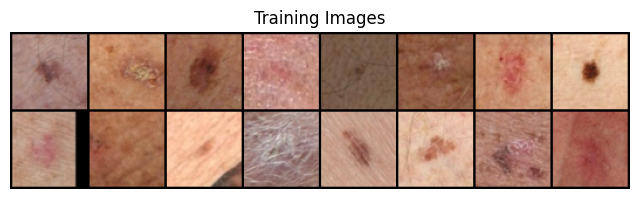

In [11]:

# Global constants
traindir = "./train-image"
image_size = 64
batch_size = 32
workers = 0
nz = 100

# Load the labels and find the label associated with malignant lesions
df = pd.read_csv('train-metadata.csv')
df = df[['isic_id','target']]
df = df[df['target'] == 1]
malignant_id = df['isic_id']
train_id = malignant_id[:293].to_list()
test_id = malignant_id[293:].to_list()

# Load the filtered images folder and dataloader
dataset = FilteredImageFolder(root=traindir, transform=transforms.Compose([transforms.Resize(image_size),transforms.CenterCrop(image_size),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]), image_list=train_id)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Show the images for test
real_batch = next(iter(dataloader))
print("***")
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
# Export the test images with malignant lesions
for id in test_id:
    img = Image.open("./train-image/image/" + id + ".jpg")
    img.save("./test_te/" + id + ".jpg")
    

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
            nn.Tanh()
        )
        
    def forward(self, w):
        return self.model(w)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )
    
    def forward(self, w):
        return self.model(w)

In [12]:
# Hyper parameters
epochs = 300
lr = 0.005
beta1 = 0.1

# Initialize the Generator and Discriminator and their optimizers
netG = Generator().to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas = (beta1, 0.99))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas = (beta1, 0.99))

# Initialize the loss function
criterion = nn.BCELoss()


In [ ]:
# Training
img_list = []
G_losses = []
D_losses = []
iters = 0
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        # Train with all-real batches
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Train with all-fake batches
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output,label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        # Update the Generator
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'% (epoch, epochs, i, len(dataloader),errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/300][0/10]	Loss_D: 1.4242	Loss_G: 45.3749	D(x): 0.5417	D(G(z)): 0.4493 / 0.0000
[1/300][0/10]	Loss_D: 30.8967	Loss_G: 2.7630	D(x): 0.5109	D(G(z)): 0.3446 / 0.3540
[2/300][0/10]	Loss_D: 15.1338	Loss_G: 2.3591	D(x): 0.9447	D(G(z)): 0.7866 / 0.2441
[3/300][0/10]	Loss_D: 8.8138	Loss_G: 10.8758	D(x): 0.3653	D(G(z)): 0.0002 / 0.0113
[4/300][0/10]	Loss_D: 25.8813	Loss_G: 4.4411	D(x): 0.7700	D(G(z)): 0.5151 / 0.4429
[5/300][0/10]	Loss_D: 2.8612	Loss_G: 5.4390	D(x): 0.7029	D(G(z)): 0.1932 / 0.1871
[6/300][0/10]	Loss_D: 0.4895	Loss_G: 5.6799	D(x): 0.8383	D(G(z)): 0.0277 / 0.0544
[7/300][0/10]	Loss_D: 26.0572	Loss_G: 3.4565	D(x): 0.7261	D(G(z)): 0.7137 / 0.3853
[8/300][0/10]	Loss_D: 1.4008	Loss_G: 7.3641	D(x): 0.5315	D(G(z)): 0.0496 / 0.0797
[9/300][0/10]	Loss_D: 11.8630	Loss_G: 12.4143	D(x): 0.0519	D(G(z)): 0.0412 / 0.4988
[10/300][0/10]	Loss_D: 0.2845	Loss_G: 4.2421	D(x): 0.8884	D(G(z)): 0.1305 / 0.1198
[11/300][0/10]	Loss_D: 0.6625	Loss_G: 10.8978	D(x): 0.9934	D(G(z)): 0.2829 / 0.0706
[12/3

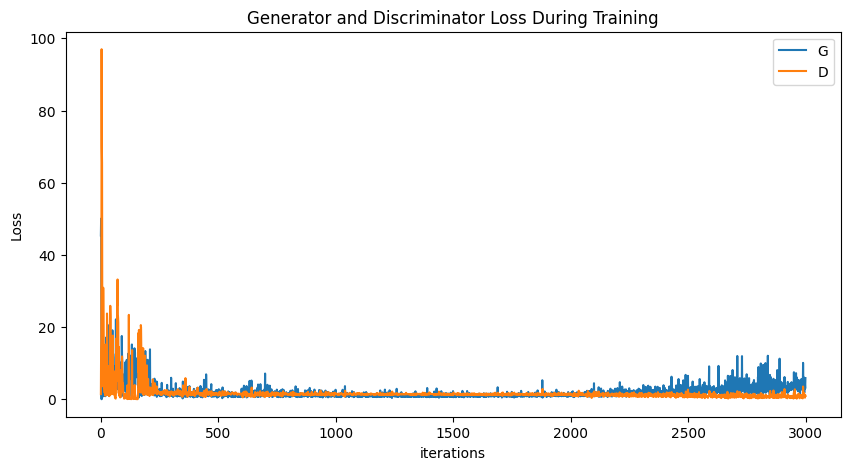

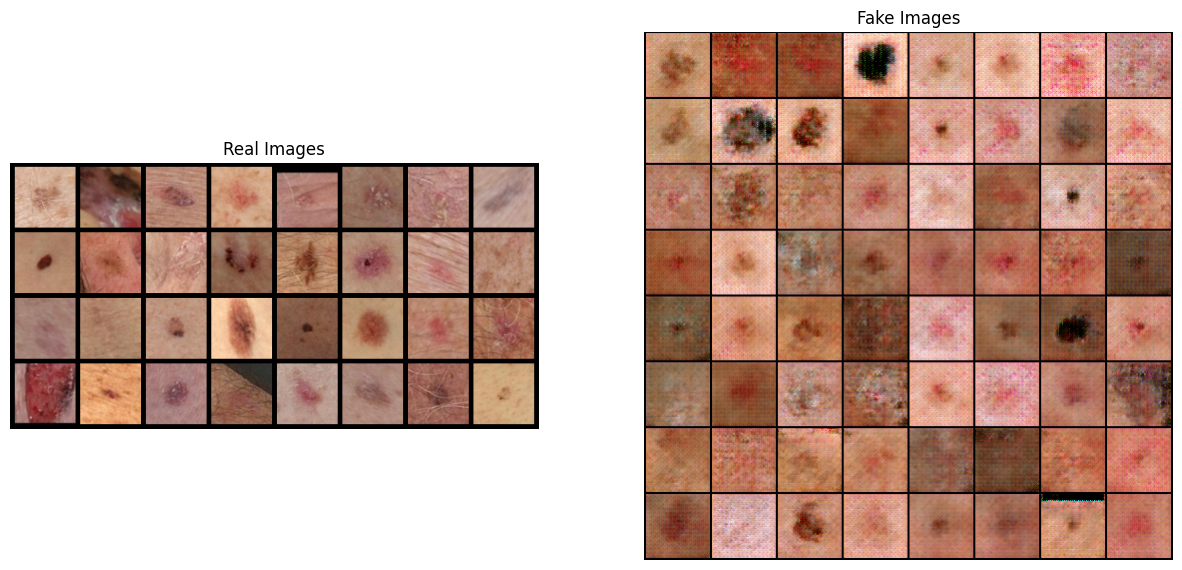

In [94]:
# Visualization
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:128], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [17]:
n_train = 500 # Constant for the number of images produced

# Export fake images for training
for i in range(n_train):
    noise = torch.randn(1, nz, 1, 1, device=device)
    fake = netG(noise).detach().cpu()
    fake = vutils.make_grid(fake, padding=2, normalize=True)
    vutils.save_image(fake, "./train_te/train_" + str(i) + ".jpg")

In [96]:
# Save the model
torch.save(netG, "netG.pth")

In [13]:
# Load the model
netG = torch.load("netG.pth", weights_only=False)